In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

from utils import rotation_matrix
#from methods import *

In [ ]:
from models import Similitude, Similitude2, RobustSimilitude
dtype=torch.float32
model = Similitude2(scale=None,ncells=14,dtype=dtype,rectify=True,dropout=True) #146.2

In [ ]:
if True:
    # Overwrite Initial Phase Placements
    start_phases = torch.normal(torch.zeros((model.ncells,2))+0.2,0.01)
    #start_phases = torch.cat([torch.normal(torch.zeros((model.ncells//2,2)),0.01),torch.normal(torch.zeros((model.ncells//2,2))+0.2,0.01)])
    
    #model = torch.load('./saved-models/Similitude2-14-dirac')
    #start_phases = model.phases.detach().numpy()
    #start_phases = np.concatenate([start_phases,start_phases@rotation_matrix(10).T+0.2])
    #start_phases = np.concatenate([start_phases,start_phases+0.2])
    
    model.set_phases(start_phases)
start_phases = model.phases.detach().numpy()

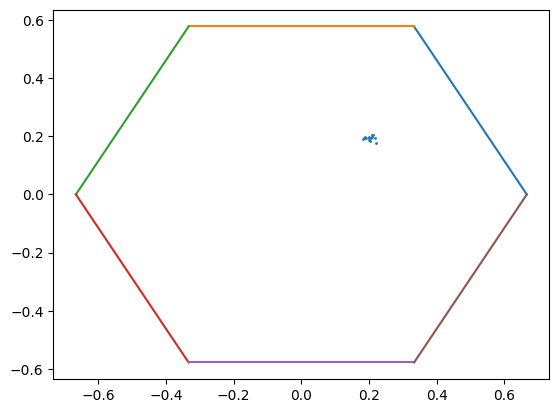

In [ ]:
fig,ax=model.unit_cell.plot()
ax.scatter(*model.phases.detach().T,s=1)

In [ ]:
# Train model
nsamples_space = 2**10
loss_history = []
phases_history = [model.phases.clone().detach().numpy()]
scale_history = []
for epoch in tqdm.trange(2000):
    rs = model.unit_cell.sample(nsamples_space)
    rs = torch.tensor(rs,dtype=dtype)
    loss = model.train_step(rs)
    loss_history.append(loss)
    phases_history.append(model.phases.clone().detach().numpy())
    scale_history.append(model.scale.clone().detach().numpy())

100%|██████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 142.73it/s]


In [ ]:
# test time to sample and time to train to see where comp. bottleneck is.
%timeit -n 20 model.unit_cell.sample(nsamples_space)
%timeit -n 20 model.train_step(rs)

445 µs ± 105 µs per loop (mean ± std. dev. of 7 runs, 20 loops each)
6.57 ms ± 76.6 µs per loop (mean ± std. dev. of 7 runs, 20 loops each)


3.1031556253140648e+19

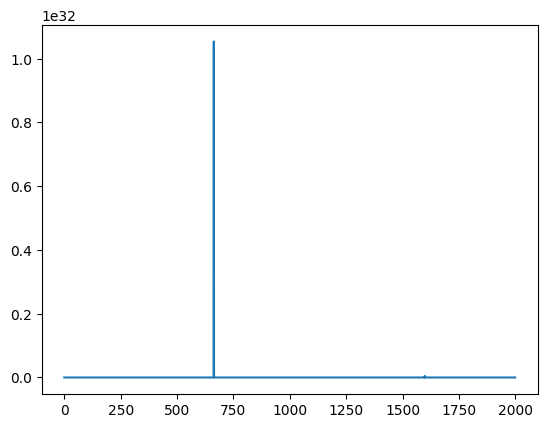

In [ ]:
#plt.semilogy(loss_history)
plt.plot(loss_history)
loss_history[-1] # -8.679537108440963

In [ ]:
plt.semilogy(scale_history)

In [ ]:
J = model.jacobian(rs)
metric_tensor = model.metric_tensor(J)

In [ ]:
fig,axs = plt.subplots(ncols=3,figsize=(9,3))
axs[0].scatter(*rs.T,c=metric_tensor[...,0,0].detach())
axs[1].scatter(*rs.T,c=metric_tensor[...,1,1].detach())
axs[2].scatter(*rs.T,c=metric_tensor[...,1,0].detach())
#plt.colorbar()

In [ ]:
N = len(phases_history)
fig, ax = plt.subplots()
[ax.scatter(*phases_history[i].T, c='grey',alpha=(i+0.2)/(N+0.2)) for i in range(0,N,10)]
ax.scatter(*phases_history[-1].T, c='red')
ax.scatter(*start_phases.T,s=10)
ax.axis('equal')
model.unit_cell.plot(fig,ax)
#model.unit_cell.plot(fig,ax,center=np.mean(phases_history[-1],axis=0))

In [ ]:
torch.save(model,f'./saved-models/{type(model).__name__}-{model.ncells}-dirac')
f'./saved-models/{type(model).__name__}-{model.ncells}-dirac'

In [ ]:
# dropout?
# figure out the geodesic between phases
# - finds hexagons